## Initial Data Visualization and Analysis

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import plotly.express as px


In [210]:
df_books_movies = pd.read_csv('../data/final_dataset.csv')
display(df_books_movies.columns)

Index(['Unnamed: 0', 'movie_id', 'movie_cluster', 'movie_name', 'release_date',
       'runtime_x', 'language', 'country', 'genres', 'movie_year', 'index',
       'id', 'BookTitle', 'BookYear', 'Author', 'full name', 'tmdb_id',
       'id_goodreads', 'imdbid', 'runtime_y', 'revenue', 'book_id',
       'normalized_rating_x', 'standardized_rating_x', 'normalized_rating_y',
       'standardized_rating_y'],
      dtype='object')

In [211]:
df_books = pd.read_csv('../data/books.csv')
display(df_books.columns)
df_filtered = df_books[['book_id', 'length', 'review_count']]
display(df_filtered.columns)

Index(['book_id', 'title', 'year', 'avg_rating', 'rating_count',
       'review_count', 'series', 'series_num', 'author', 'description',
       'length', 'five_stars', 'four_stars', 'three_stars', 'two_stars',
       'one_star', 'cover_image', 'standardized_rating', 'normalized_rating'],
      dtype='object')

Index(['book_id', 'length', 'review_count'], dtype='object')

In [212]:
df_merged = df_books_movies.merge(df_filtered, how = 'left',on= 'book_id')
display(df_merged.columns)

Index(['Unnamed: 0', 'movie_id', 'movie_cluster', 'movie_name', 'release_date',
       'runtime_x', 'language', 'country', 'genres', 'movie_year', 'index',
       'id', 'BookTitle', 'BookYear', 'Author', 'full name', 'tmdb_id',
       'id_goodreads', 'imdbid', 'runtime_y', 'revenue', 'book_id',
       'normalized_rating_x', 'standardized_rating_x', 'normalized_rating_y',
       'standardized_rating_y', 'length', 'review_count'],
      dtype='object')

### Book Length Distribution

In [213]:
unique_books = df_merged[['length', 'book_id', 'BookTitle', 'Author', 'normalized_rating_y', 'BookYear', 'review_count']].drop_duplicates(subset='book_id')

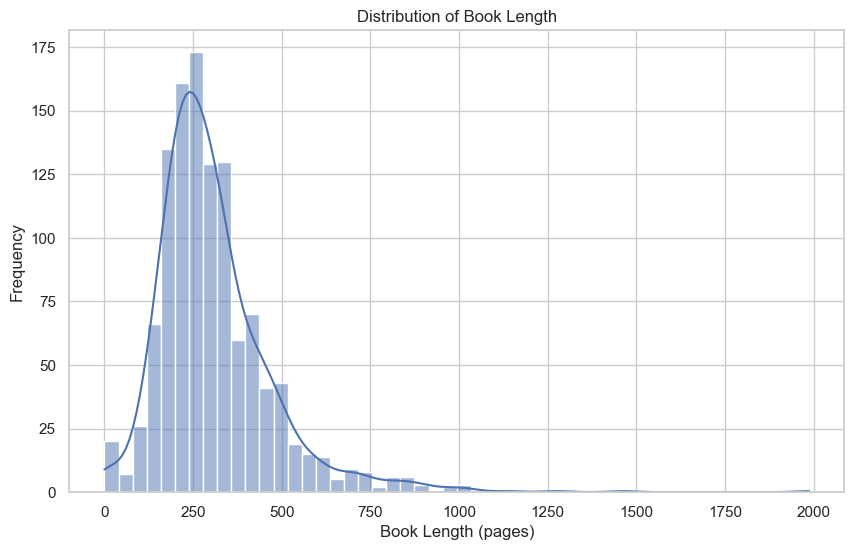

In [214]:
plt.figure(figsize=(10, 6))
sns.histplot(unique_books['length'], bins=50, kde=True)
plt.title('Distribution of Book Length')
plt.xlabel('Book Length (pages)')
plt.ylabel('Frequency')
plt.show()


## Comparison of Revenue with Book and Movie Ratings

In [215]:
df_revenue = df_merged.dropna(subset=['revenue']).query('revenue != 0')
print(len(df_merged), len(df_revenue))

1972 1014


In [250]:
fig = px.scatter(
    df_revenue,
    x='revenue',
    y='normalized_rating_y',
    hover_name='movie_name',
    title='Revenue vs. Book Ratings',
    labels={'revenue': 'Movie Revenue ($), logscale', 'normalized_rating_y': 'Normalized Book Rating'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_type="log",
    width=1000, 
    height=600
)
fig.show()


In [253]:
# We want to check which movies are successful based on the two characteristics revenue and movie ratings. We will show four quadrants each containing about a quarter of movies. 
def assign_quadrant(row, revenue_median, rating_median, revenue_column):
    if row[revenue_column] < revenue_median and row['normalized_rating_x'] < rating_median:
        return 'Low Rating & Low Revenue'
    elif row[revenue_column] < revenue_median and row['normalized_rating_x'] >= rating_median:
        return 'High Rating & Low Revenue'
    elif row[revenue_column] >= revenue_median and row['normalized_rating_x'] < rating_median:
        return 'Low Rating & High Revenue'
    else:
        return 'High Rating & High Revenue'
    

def quadrant_revenue(df_revenue, revenue_column, title):

    revenue_median = df_revenue[revenue_column].median()
    rating_median = df_revenue['normalized_rating_x'].median()

    df_revenue['Success Cathegory'] = df_revenue.apply(lambda row: assign_quadrant(row, revenue_median, rating_median, revenue_column), axis=1)

    fig = px.scatter(
        df_revenue,
        x=revenue_column,
        y='normalized_rating_x',
        hover_name='movie_name',
        color='Success Cathegory',
        title= title,
        labels={revenue_column: 'Movie Revenue ($), logscale', 'normalized_rating_x': 'Normalized Movie Rating'},
        template='plotly_white'
    )

    fig.add_shape(
        type='line',
        x0=revenue_median, x1=revenue_median,
        y0=df_revenue['normalized_rating_x'].min(), y1=df_revenue['normalized_rating_x'].max(),
        line=dict(color='Gray', width=1, dash="dash")
    )

    fig.add_shape(
        type='line',
        x0=df_revenue[revenue_column].min(), x1=df_revenue[revenue_column].max(),
        y0=rating_median, y1=rating_median,
        line=dict(color='Gray', width=1, dash="dash")
    )

    fig.update_layout(
        xaxis_type="log",
        width=1000,
        height=600
    )

    fig.show()

quadrant_revenue(df_revenue, 'revenue', title='Revenue vs. Movie Ratings')

## Revenue Adaptation for inflation
We use the same approach as discussed in this article: https://towardsdatascience.com/adjusting-prices-for-inflation-in-pandas-daaaa782cd89 

We use the data from here: https://fred.stlouisfed.org/series/CPIAUCNS 

In [241]:
inflation = pd.read_csv('../data/CPIAUCNS.csv', parse_dates=['DATE'])

inflation['Year'] = inflation['DATE'].dt.year

inflation_yearly = inflation.groupby('Year')['CPIAUCNS'].mean().reset_index()
inflation_yearly.columns = ['Year', 'CPI']

base_year = df_merged.movie_year.max()
base_cpi = inflation_yearly[inflation_yearly['Year'] == base_year]['CPI'].values[0]

df_revenue = df_revenue.merge(inflation_yearly, left_on='movie_year', right_on='Year', how='left')


In [271]:

df_revenue['AdjustedRevenue'] = df_revenue['revenue'] * (base_cpi / df_revenue['CPI'])

fig = px.scatter(
    title="Original vs. Inflation-Adjusted Revenue (base year = 2013) of Movies"
)

fig.add_scatter(
    x=df_revenue['movie_year'],
    y=df_revenue['revenue'],
    mode='markers',
    name='Original Revenue',
    marker=dict(color='blue'),
    hovertext=df_revenue['BookTitle']
)

fig.add_scatter(
    x=df_revenue['movie_year'],
    y=df_revenue['AdjustedRevenue'],
    mode='markers',
    name='Adjusted Revenue',
    marker=dict(color='red'),
    hovertext=df_revenue['BookTitle']
)

fig.update_layout(
    xaxis=dict(title='Release Year'),
    yaxis=dict(type='log', title='Revenue (USD), log scale'),
    showlegend=True
)

fig.show()

Let's plot the same thing as before but with the adjusted Revenues

In [254]:
quadrant_revenue(df_revenue, 'AdjustedRevenue', title='Adjusted Revenue vs. Movie Ratings')

## Top 10 Authors with the most different Books adapted into Movies

Text(0.5, 1.0, 'Top 10 Authors by Book Count')

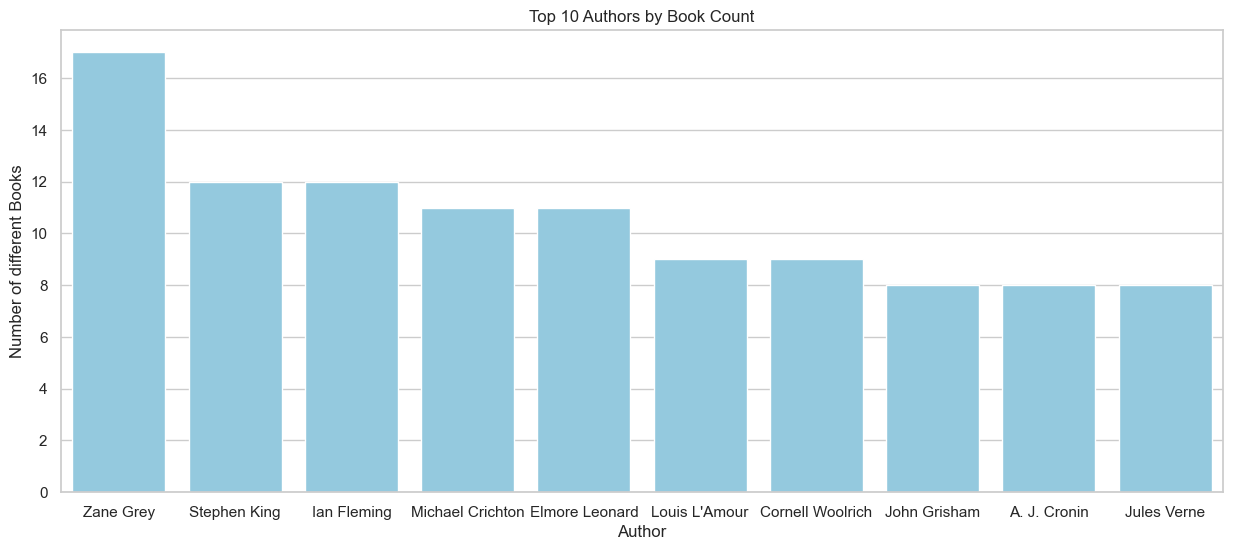

In [227]:
unique_books_author = unique_books[unique_books.Author != '0']
author_stats = unique_books_author.groupby('Author').agg(book_count=('BookTitle', 'size')).sort_values(by='book_count', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(15, 6))

sns.barplot(x=author_stats.index, y=author_stats['book_count'], color='skyblue', ax=ax1)
ax1.set_ylabel('Number of different Books')
ax1.set_xlabel('Author')
ax1.set_title('Top 10 Authors by Book Count')


## Release Year of the Book

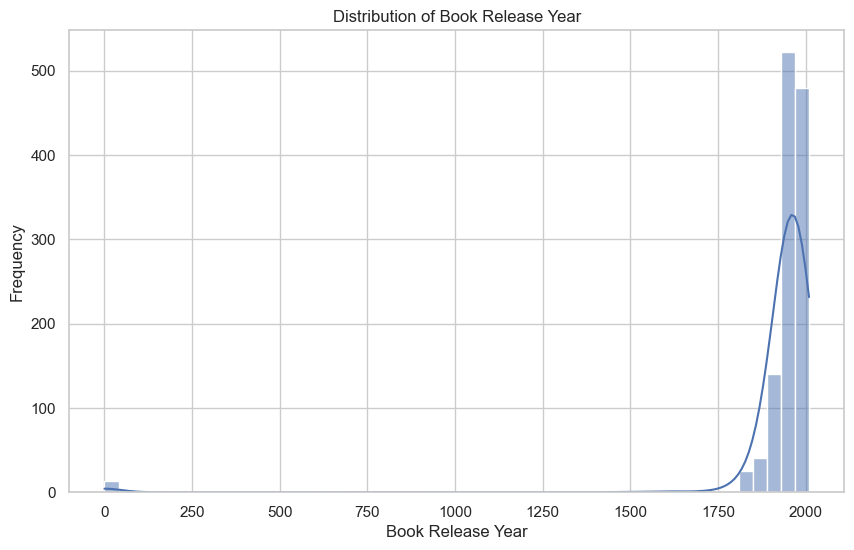

In [228]:
plt.figure(figsize=(10, 6))
sns.histplot(unique_books['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()


In [229]:
display(unique_books[unique_books.BookYear <= 50])

,length,book_id,BookTitle,Author,normalized_rating_y,BookYear,review_count
242,280.0,46437.0,Background to Danger,Eric Ambler,0.623333,0,72.0
293,320.0,13109354.0,One Thousand and One Nights,0,0.596667,0,211.0
645,541.0,1381.0,Odyssey,Homer,0.583333,0,9990.0
743,224.0,25309336.0,The Rebel Outlaw: Josey Wales,Asa Earl Carter,0.686667,0,52.0
770,181.0,162332.0,The Sailor Who Fell from Grace with the Sea,Yukio Mishima,0.630000,0,1047.0
1061,303.0,685970.0,"(1967), William Bradford Huie",0,0.450000,0,0.0
1183,272.0,58314.0,Les Particules Élémentaires,Michel Houellebecq,0.596667,0,1566.0
1438,283.0,4858198.0,A Job for Jenny,Faith Baldwin,0.466667,0,0.0
1451,213.0,52357.0,Beowulf,unknown,0.476667,0,5648.0
1466,132.0,747651.0,Biruma no tategoto,Michio Takeyama,0.560000,0,86.0


Some of these books are actually written a very long time ago (like Odyssey from Homer for example), but others just don't seem to have the correct year (like Background to Danger from 1937). Let's exclude them for now from the analysis, since they are only a few. 

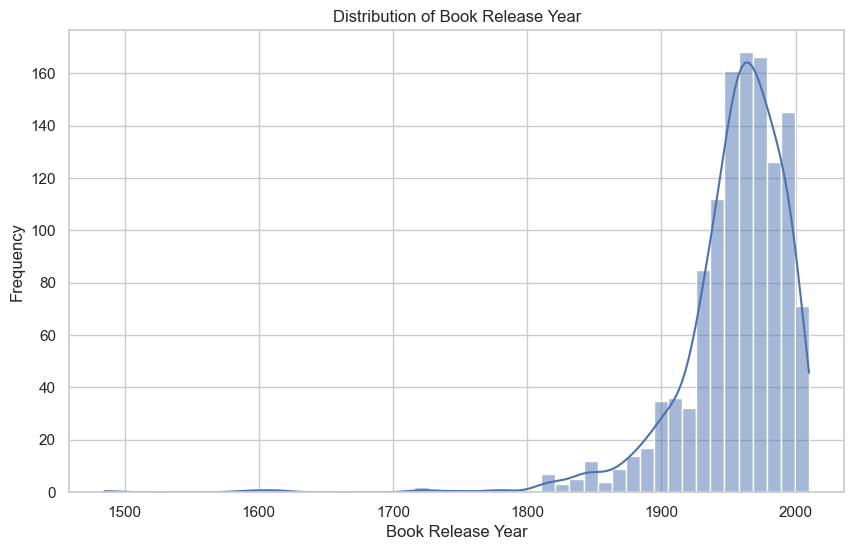

In [230]:
unique_books_year = unique_books[unique_books.BookYear != 0]
plt.figure(figsize=(10, 6))
sns.histplot(unique_books_year['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()

## How much time goes by between a Book and Movie Release?

In [231]:
year_book_movie = df_merged.dropna(subset=['BookYear', 'movie_year'])
year_book_movie = year_book_movie[year_book_movie['BookYear']!=0]
year_book_movie['years_to_movie'] = year_book_movie['movie_year'] - year_book_movie['BookYear']

fig = px.scatter(
    year_book_movie,
    x='movie_year',
    y='years_to_movie',
    hover_data={'BookTitle': True, 'BookYear': True, 'movie_year': True, 'years_to_movie': True},
    title='Years Between Book and Movie Release',
    labels={'BookYear': 'Book Release Year', 'years_to_movie': 'Years to Movie Release'},
    template='plotly_white'
)

fig.update_traces(
    hovertemplate='<b>Book Title:</b> %{customdata[0]}<br>' +
                  '<b>Book Release Year:</b> %{customdata[1]}<br>' +
                  '<b>Movie Release Year:</b> %{x}<br>' +
                  '<b>Years to Movie Release:</b> %{y}<br>'
)

fig.show()


There seems to be something weird going on for the Tarzan movies... After some quick research, we found out that while in 1995 the last written work for a Tarzan novel was found, the original books were released much sooner. 

## Serial Adaptations
For some Research Questions we will only look at Books that have been adapted into movies several times. We should identify them and see how many there are

In [232]:
book_adaptations = df_merged.groupby(['book_id', 'BookTitle']).size().reset_index(name='adaptation_count')

# Sort by 'adaptation_count' in descending order to see the most frequently adapted books
book_adaptations = book_adaptations.sort_values(by='adaptation_count', ascending=False)

# Display the top books with the most adaptations
print(book_adaptations[book_adaptations.adaptation_count > 1])


         book_id                              BookTitle  adaptation_count
191      40425.0                                 Tarzan                39
1215  35031085.0                           Frankenstein                23
221      51499.0  Strange Case of Dr Jekyll and Mr Hyde                17
424     236093.0             The Wonderful Wizard of Oz                15
73        7190.0                Les Trois Mousquetaires                14
...          ...                                    ...               ...
980    2429135.0                             Millennium                 2
112      15241.0                  The Lord of the Rings                 2
487     348573.0                          The Borrowers                 2
896    1492337.0                      Fighting Caravans                 2
128      18512.0                  The Lord of the Rings                 2

[256 rows x 3 columns]


In [233]:
#Let's say we are only interested in books that have been adapted more than 5 times
top_adapted_books = book_adaptations[book_adaptations.adaptation_count > 5]

fig = px.bar(
    top_adapted_books,
    x='BookTitle',
    y='adaptation_count',
    title='Books adapted more than 5 times',
    labels={'BookTitle': 'Book Title', 'adaptation_count': 'Number of Adaptations'},
    template='plotly_white'
)

fig.update_traces(
    hovertemplate='<b>Book Title:</b> %{x}<br><b>Adaptation Count:</b> %{y}<extra></extra>'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()
